In [3]:
# more common imports
import pandas as pd
import numpy as np
from collections import Counter
import re
import os

# languange processing imports
import nltk
from gensim.corpora import Dictionary
# preprocessing imports
from sklearn.preprocessing import LabelEncoder

# model imports
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.word2vec import Word2Vec
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
# hyperparameter training imports
from sklearn.model_selection import GridSearchCV

# visualization imports
from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import base64
import io
%matplotlib inline
sns.set()  # defines the style of the plots to be seaborn style

C:\Users\edufe\Anaconda3\lib\site-packages\smart_open\ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')
C:\Users\edufe\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


# Abre os dados

In [4]:
A = pd.read_excel("../Filter/Sanity.xlsx", sep=",", header=None)
Carros = str(list(A.iloc[0])[0]).split(",")
Frutas = str(list(A.iloc[1])[0]).split(",")
Animais = str(list(A.iloc[2])[0]).split(",")

In [5]:
import random
 
X = []
n_samples = 1000
Textlens = 10

for i in range(n_samples):
    List = random.randint(1,3)
    if List == 1:
        ThisItem = random.choice(Carros).lower() 
        for j in range(Textlens):
            ThisItem = ThisItem + " " + random.choice(Carros).lower() 
    if List == 2:
        ThisItem = random.choice(Frutas).lower() 
        for j in range(Textlens):
            ThisItem = ThisItem + " " + random.choice(Frutas).lower() 
    if List == 3:
        ThisItem = random.choice(Animais).lower() 
        for j in range(Textlens):
            ThisItem = ThisItem + " " + random.choice(Animais).lower() 
            
    X.append(ThisItem) 

In [10]:
AllData = pd.DataFrame({"Texto":X})
AllData.sample(5)

,Texto
566,zafira hafei journey tracker kia hafei ...
947,jerivá rambai fruta-do-milagre kabosu pupunha ...
540,celer sedan strada r8 fiorino gla transi...
2,effa hafei ec7 classe c 63 amg touring q3 ...
24,tucson classe amarok palio bravo astra ha...


In [12]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\edufe\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\edufe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\edufe\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [11]:
# Here we get transform the documents into sentences for the word2vecmodel
# we made a function such that later on when we make the submission, we don't need to write duplicate code
def w2v_preprocessing(df):
    """ All the preprocessing steps for word2vec are done in this function.
    All mutations are done on the dataframe itself. So this function returns
    nothing.
    """
    df['document_sentences'] = df.Texto.str.split('.')  # split texts into individual sentences
    df['tokenized_sentences'] = list(map(lambda sentences:
                                         list(map(nltk.word_tokenize, sentences)),
                                         df.document_sentences))  # tokenize sentences
    df['tokenized_sentences'] = list(map(lambda sentences:
                                         list(sentences),
                                         df.tokenized_sentences))  # remove unwanted characters
    df['tokenized_sentences'] = list(map(lambda sentences:
                                         list(filter(lambda lst: lst, sentences)),
                                         df.tokenized_sentences))  # remove empty lists

w2v_preprocessing(AllData)

In [12]:
AllData.sample(5)

,Texto,document_sentences,tokenized_sentences
605,imbu akee camu-camu pêssego cranberry pera cam...,[imbu akee camu-camu pêssego cranberry pera ca...,"[[imbu, akee, camu-camu, pêssego, cranberry, p..."
591,cobalt série 7 sedã effa 320 picape cabin...,[ cobalt série 7 sedã effa 320 picape cabi...,"[[cobalt, série, 7, sedã, effa, 320, picape, c..."
886,biribá granadilla alfarroba gabiroba murici pu...,[biribá granadilla alfarroba gabiroba murici p...,"[[biribá, granadilla, alfarroba, gabiroba, mur..."
893,fruta com r baru murici tucumã bacupari pitang...,[fruta com r baru murici tucumã bacupari pitan...,"[[fruta, com, r, baru, murici, tucumã, bacupar..."
16,cirurgiões agapornis gato cardeal petauro de a...,[cirurgiões agapornis gato cardeal petauro de ...,"[[cirurgiões, agapornis, gato, cardeal, petaur..."


In [13]:
def lda_get_good_tokens(df):
    df['tokenized_text'] = list(map(nltk.word_tokenize, df.Texto))
    df['tokenized_text'] = list(df.tokenized_text)

lda_get_good_tokens(AllData)

In [14]:
AllData.sample(5)

,Texto,document_sentences,tokenized_sentences,tokenized_text
98,uva quiuí langsat marmelo engkala murici noz-p...,[uva quiuí langsat marmelo engkala murici noz-...,"[[uva, quiuí, langsat, marmelo, engkala, muric...","[uva, quiuí, langsat, marmelo, engkala, murici..."
37,calamondin tucujá nectarina meloa lucuma karit...,[calamondin tucujá nectarina meloa lucuma kari...,"[[calamondin, tucujá, nectarina, meloa, lucuma...","[calamondin, tucujá, nectarina, meloa, lucuma,..."
341,ducato astra sedan gla freelander 2 effa ...,[ ducato astra sedan gla freelander 2 effa...,"[[ducato, astra, sedan, gla, freelander, 2, ef...","[ducato, astra, sedan, gla, freelander, 2, eff..."
206,pitangatuba inharé babaçu sapoti kumquat figo-...,[pitangatuba inharé babaçu sapoti kumquat figo...,"[[pitangatuba, inharé, babaçu, sapoti, kumquat...","[pitangatuba, inharé, babaçu, sapoti, kumquat,..."
18,cavalo poecilídeos porco doméstico piriquitos ...,[cavalo poecilídeos porco doméstico piriquitos...,"[[cavalo, poecilídeos, porco, doméstico, piriq...","[cavalo, poecilídeos, porco, doméstico, piriqu..."


In [15]:
tokenized_only_dict = Counter(np.concatenate(AllData.tokenized_text.values))

tokenized_only_df = pd.DataFrame.from_dict(tokenized_only_dict, orient='index')
tokenized_only_df.rename(columns={0: 'count'}, inplace=True)

tokenized_only_df.sort_values('count', ascending=False, inplace=True)

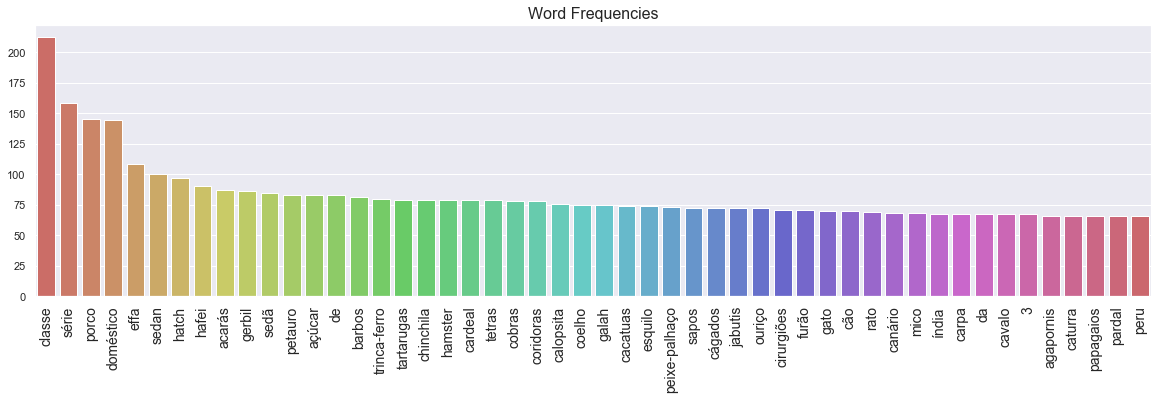

In [16]:
def word_frequency_barplot(df, nr_top_words=50):
    """ df should have a column named count.
    """
    fig, ax = plt.subplots(1,1,figsize=(20,5))

    sns.barplot(list(range(nr_top_words)), df['count'].values[:nr_top_words], palette='hls', ax=ax)

    ax.set_xticks(list(range(nr_top_words)))
    ax.set_xticklabels(df.index[:nr_top_words], fontsize=14, rotation=90)
    return ax
    
ax = word_frequency_barplot(tokenized_only_df)
ax.set_title("Word Frequencies", fontsize=16);

In [17]:
def remove_stopwords(df):
    """ Removes stopwords based on a known set of stopwords
    available in the nltk package. In addition, we include our
    made up word in here.
    """
    # Luckily nltk already has a set of stopwords that we can remove from the texts.
    stopwords = nltk.corpus.stopwords.words('portuguese')
    
    del(stopwords[stopwords.index("não")])
    ManualStop = ["istoégente", "expressoepoca", "globonews", "estudioi", "rt", "andreiasadi",
                  "’", "‘", "”", "“", "r", ",", "."]
    for i in ManualStop:
        stopwords.append(i)
    
    df['stopwords_removed'] = list(map(lambda doc:
                                       [word for word in doc if word not in stopwords],
                                       df['tokenized_text']))

remove_stopwords(AllData)

In [18]:
#Não Funciona em PT

def stem_words(df):
    lemm = nltk.stem.WordNetLemmatizer()
    df['lemmatized_text'] = list(map(lambda sentence:
                                     list(map(lemm.lemmatize, sentence)),
                                     df.stopwords_removed))

    p_stemmer = nltk.stem.porter.PorterStemmer()
    df['stemmed_text'] = list(map(lambda sentence:
                                  list(map(p_stemmer.stem, sentence)),
                                  df.lemmatized_text))

In [19]:
dictionary = Dictionary(documents=AllData.stopwords_removed.values)

print("Found {} words.".format(len(dictionary.values())))

Found 500 words.


In [20]:
dictionary.filter_extremes(no_above=0.8, no_below=3)

dictionary.compactify()  # Reindexes the remaining words after filtering
print("Left with {} words.".format(len(dictionary.values())))

Left with 500 words.


In [21]:
def document_to_bow(df):
    df['bow'] = list(map(lambda doc: dictionary.doc2bow(doc), df.stopwords_removed))
    
document_to_bow(AllData)

In [22]:
def lda_preprocessing(df):
    """ All the preprocessing steps for LDA are combined in this function.
    All mutations are done on the dataframe itself. So this function returns
    nothing.
    """
    lda_get_good_tokens(df)
    remove_stopwords(df)
    document_to_bow(df)

In [23]:
cleansed_words_df = pd.DataFrame.from_dict(dictionary.token2id, orient='index')
cleansed_words_df.rename(columns={0: 'id'}, inplace=True)

cleansed_words_df['count'] = list(map(lambda id_: dictionary.dfs.get(id_), cleansed_words_df.id))
del cleansed_words_df['id']

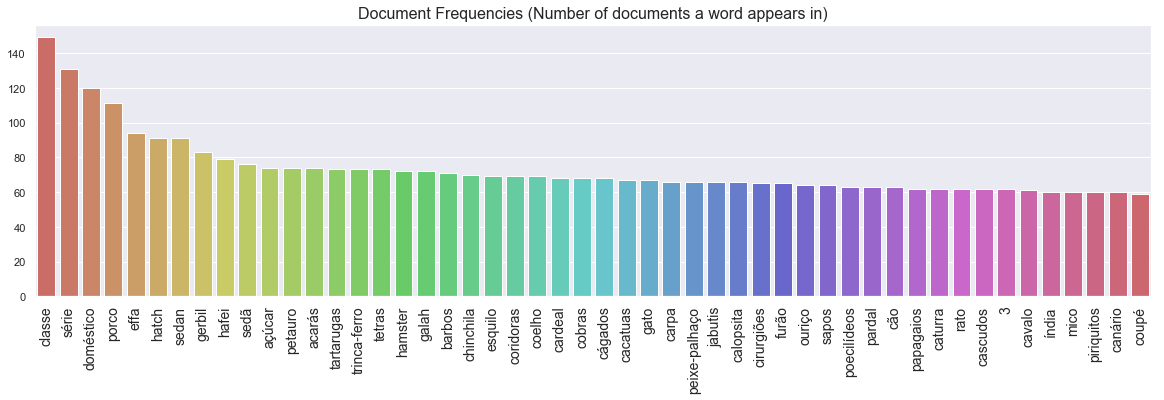

In [24]:
cleansed_words_df.sort_values('count', ascending=False, inplace=True)
ax = word_frequency_barplot(cleansed_words_df)
ax.set_title("Document Frequencies (Number of documents a word appears in)", fontsize=16);                              

In [25]:
AllData.sample(5)

,Texto,document_sentences,tokenized_sentences,tokenized_text,stopwords_removed,bow
815,série 3 m3 coupé freelander 2 azera celer ...,[ série 3 m3 coupé freelander 2 azera celer...,"[[série, 3, m3, coupé, freelander, 2, azera, c...","[série, 3, m3, coupé, freelander, 2, azera, ce...","[série, 3, m3, coupé, freelander, 2, azera, ce...","[(27, 1), (133, 1), (160, 1), (162, 1), (213, ..."
350,linea i3 458 strada classe g tt coupé x...,[ linea i3 458 strada classe g tt coupé ...,"[[linea, i3, 458, strada, classe, g, tt, coupé...","[linea, i3, 458, strada, classe, g, tt, coupé,...","[linea, i3, 458, strada, classe, g, tt, coupé,...","[(16, 1), (19, 1), (23, 1), (141, 1), (194, 1)..."
464,petauro de açúcar petauro de açúcar cacatuas c...,[petauro de açúcar petauro de açúcar cacatuas ...,"[[petauro, de, açúcar, petauro, de, açúcar, ca...","[petauro, de, açúcar, petauro, de, açúcar, cac...","[petauro, açúcar, petauro, açúcar, cacatuas, c...","[(60, 2), (62, 1), (63, 1), (68, 1), (70, 2), ..."
379,oscar acarás cardeal perereca canário-da-terra...,[oscar acarás cardeal perereca canário-da-terr...,"[[oscar, acarás, cardeal, perereca, canário-da...","[oscar, acarás, cardeal, perereca, canário-da-...","[oscar, acarás, cardeal, perereca, canário-da-...","[(64, 1), (66, 1), (69, 1), (163, 2), (166, 1)..."
743,r8 sorento gallardo lp 560 – 4 ix35 q5 sé...,[ r8 sorento gallardo lp 560 – 4 ix35 q5 s...,"[[r8, sorento, gallardo, lp, 560, –, 4, ix35, ...","[r8, sorento, gallardo, lp, 560, –, 4, ix35, q...","[r8, sorento, gallardo, lp, 560, –, 4, ix35, q...","[(152, 1), (190, 1), (191, 1), (216, 1), (251,..."


# Análise de tópicos

In [26]:
corpus = AllData.bow

In [27]:
num_topics = 30
#A multicore approach to decrease training time
LDAmodel = LdaMulticore(corpus=corpus,
                        id2word=dictionary,
                        num_topics=num_topics,
                        workers=11,
                        chunksize=10000,
                        iterations = 5,
                        passes=7,
                        alpha='asymmetric')

In [28]:
def document_to_lda_features(lda_model, document):
    """ Transforms a bag of words document to features.
    It returns the proportion of how much each topic was
    present in the document.
    """
    topic_importances = LDAmodel.get_document_topics(document, minimum_probability=0)
    topic_importances = np.array(topic_importances)
    return topic_importances[:,1]

AllData['lda_features'] = list(map(lambda doc:
                              document_to_lda_features(LDAmodel, doc),
                              AllData.bow))

In [30]:
def get_topic_top_words(lda_model, topic_id, nr_top_words=5):
    """ Returns the top words for topic_id from lda_model."""
    id_tuples = lda_model.get_topic_terms(topic_id, topn=nr_top_words)
    word_ids = np.array(id_tuples)[:,0]
    words = map(lambda id_: lda_model.id2word[id_], word_ids)
    return words

In [31]:
print("Looking up top words from top topics")
for x in range(num_topics):
    top_words = get_topic_top_words(LDAmodel, x, nr_top_words=10)
    print("For topic {}, the top words are: {}.".format(x+1, ", ".join(top_words)))
print("")

Looking up top words from top topics
For topic 1, the top words are: castanha, feijoa, oiti, cupuaçu, langsat, tapiá, bergamota, saguaraji, noz-pecã, pará.
For topic 2, the top words are: roadster, ferrari, z4, classe, coupe, gol, family, siena, chana, sedan.
For topic 3, the top words are: seriguela, jambolão, castanha, rambutão, uxi, goiaba, nêspera, morango, pará, noni.
For topic 4, the top words are: vantage, v8, coupe, fiat, r8, space, cross, gla, golf, série.
For topic 5, the top words are: nectarina, guabiju, babaco, saputá, lima, dovyalis, araçá, fruta-do-conde, calabura, ciriguela.
For topic 6, the top words are: esfregadinha, tamarindo, umbu, pitanga, melão, calabaça, bacupari, sapucaia, inharé, cambuci.
For topic 7, the top words are: 4, classe, –, lp, 560, gallardo, spyder, s, hybrid, 400.
For topic 8, the top words are: jaca, kumquat, cabeludinha, caju, murici, jatobá, pequi, cagaita, lichia, calamondin.
For topic 9, the top words are: fusca, passageiro, tiguan, freemont, 